In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Import imblearn dependencies
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline
from collections import Counter
from numpy import where

In [2]:
cleaned_water_pump = pd.read_csv("./Data/cleaned_water_pump.csv")

In [3]:
cleaned_water_pump.isna().sum()

amount_tsh                     0
gps_height                     0
basin                          0
region                         0
region_code                    0
lga                            0
public_meeting                 0
scheme_management              0
permit                         0
extraction_type_group          0
extraction_type_class          0
management                     0
management_group               0
payment                        0
quality_group                  0
quantity                       0
source                         0
source_class                   0
waterpoint_type                0
status_group                   0
unknown_construction_yr        0
age_at_inspection          20708
water_per_person           21380
dtype: int64

In [3]:
cleaned_water_pump["region_code"]= cleaned_water_pump["region_code"].astype(str)

In [6]:
cleaned_water_pump.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59399 entries, 0 to 59398
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   amount_tsh               59399 non-null  float64
 1   gps_height               59399 non-null  int64  
 2   basin                    59399 non-null  object 
 3   region                   59399 non-null  object 
 4   region_code              59399 non-null  object 
 5   lga                      59399 non-null  object 
 6   public_meeting           59399 non-null  object 
 7   scheme_management        59399 non-null  object 
 8   permit                   59399 non-null  object 
 9   extraction_type_group    59399 non-null  object 
 10  extraction_type_class    59399 non-null  object 
 11  management               59399 non-null  object 
 12  management_group         59399 non-null  object 
 13  payment                  59399 non-null  object 
 14  quality_group         

In [4]:
#Set X and Y 
X = cleaned_water_pump.drop("status_group", axis=1)
y = cleaned_water_pump["status_group"]

In [5]:
#Break into numeric and categorical columns 
numeric_cols = ["amount_tsh", "gps_height", 
                "age_at_inspection", "water_per_person"]
cat_cols =["basin", "region", "region_code", "lga", "public_meeting", "scheme_management", "permit",
          "extraction_type_group", "extraction_type_class", "management", "management_group", "payment", "quality_group",
          "quantity", "source", "source_class", "waterpoint_type"]
bool_cols = ["unknown_construction_yr"]

In [6]:
#Train Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [43]:
X_train.head()

,amount_tsh,gps_height,basin,region,region_code,lga,public_meeting,scheme_management,permit,extraction_type_group,...,management_group,payment,quality_group,quantity,source,source_class,waterpoint_type,unknown_construction_yr,age_at_inspection,water_per_person
42186,0.0,143,Wami / Ruvu,Pwani,6,Kibaha,True,VWC,True,mono,...,user-group,never pay,good,enough,river,surface,communal standpipe multiple,False,36.0,0.0
22629,0.0,0,Lake Victoria,Mwanza,17,Magu,Unknown,WUG,False,nira/tanira,...,user-group,unknown,good,enough,shallow well,groundwater,hand pump,True,NaN,NaN
13789,0.0,0,Lake Tanganyika,Shinyanga,17,Bukombe,True,Parastatal,False,gravity,...,parastatal,unknown,good,seasonal,rainwater harvesting,surface,communal standpipe,True,NaN,NaN
15697,3000.0,1120,Lake Rukwa,Rukwa,15,Mpanda,True,VWC,True,india mark ii,...,user-group,pay annually,good,insufficient,machine dbh,groundwater,hand pump,False,21.0,75.0
29893,0.0,405,Ruvuma / Southern Coast,Mtwara,90,Masasi,True,VWC,True,other,...,user-group,unknown,good,dry,shallow well,groundwater,other,False,38.0,0.0


## Pipeline 

In [7]:
#Create subtypes
subpipe_num = Pipeline(steps=[("num_impute", SimpleImputer(strategy="mean")),("ss", StandardScaler())])
subpipe_cat = Pipeline(steps=[("ohe", OneHotEncoder(sparse=False, handle_unknown="ignore"))])
subpipe_ord = Pipeline(steps= [("ord_encode", OrdinalEncoder())])

In [8]:
#Column Transformers
CT = ColumnTransformer(transformers=[
                                    ("subpipe_num", subpipe_num, numeric_cols), 
                                     ("subpipe_cat", subpipe_cat, cat_cols),
                                    ("subpipe_ord", subpipe_ord, bool_cols)
                                    ], 
                       remainder="drop"
                      )

In [11]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        Args:
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)
        '''
        cv_X = X if X else self.X
        cv_y = y if y else self.y
        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )
        return ax

## Dummy Model

In [12]:
dummy_model_pipe = Pipeline(steps=[('ct', CT), ('dummy_model', DummyClassifier(strategy="most_frequent",random_state=42))])

In [13]:
dummy_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                 

In [14]:
#Accuracy Scores 
dummy_model_pipe.score(X_train, y_train)


0.5416058721856832

In [15]:
dummy_model_results = ModelWithCV(
                                  model = dummy_model_pipe,
                                  model_name = "dummy",
                                  X=X_train,
                                  y=y_train
)

In [16]:
dummy_model_results.print_cv_summary()

CV Results for `dummy` model:
            0.54161 ± 0.00007 accuracy
        


In [ ]:
#Print classification report

y_preds = dummy_model_pipe(X_test)

print(classification_report(y_test, y_preds)

## Logistic Regression Model

In [ ]:
logreg_model_pipe = Pipeline(steps=[('ct', CT), ('log_reg_model', LogisticRegression(max_iter = 850, random_state=42))])


In [ ]:
logreg_model_pipe.fit(X_train, y_train)

In [ ]:
logreg_model_pipe.score(X_train, y_train)

In [ ]:
logreg_model_results = ModelWithCV(
                                  model = logreg_model_pipe,
                                  model_name = "logreg",
                                  X=X_train,
                                  y=y_train
)

In [ ]:
logreg_model_results.print_cv_summary()

In [ ]:
#Print classification report
y_preds = logreg_model_pipe(X_test)

print(classification_report(y_test, y_preds)

## Random Forest Model

In [10]:
rfc_model_pipe = Pipeline(steps=[('ct', CT), ('rfc_model', RandomForestClassifier(random_state=42))])


In [ ]:
rfc_model_pipe.fit(X_train, y_train)

In [ ]:
rfc_model_pipe.score(X_train, y_train)

In [ ]:
rfc_model_results = ModelWithCV(
                                  model = rfc_model_pipe,
                                  model_name = "rfc",
                                  X=X_train,
                                  y=y_train
)

In [ ]:
rfc_model_results.print_cv_summary()

In [ ]:
#Print classification report
y_preds = rfc_model_pipe.predict(X_test)

print(classification_report(y_test, y_preds)

## GridSearch 

In [11]:
#Grid search using params for our rfc model 
params = { "rfc_model__n_estimators": [50, 100, 150],
        "rfc_model__criterion": ["gini", "entropy"],
         "rfc_model__min_samples_leaf": [5, 10, 30]}

gs = GridSearchCV(estimator = rfc_model_pipe,
                 param_grid=params,
                 cv=5)

In [12]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         ['amount_tsh',
                                                                          'gps_height',
                                                                          'age_at_inspection',
                                                                          'water_per_person']),
                                                             

In [15]:
basic_rfc_best = gs.best_params_

{'rfc_model__criterion': 'gini',
 'rfc_model__min_samples_leaf': 5,
 'rfc_model__n_estimators': 100}

In [14]:
gs.best_score_

0.7804440231753436

{'rfc_model__criterion': 'gini',
 'rfc_model__min_samples_leaf': 5,
 'rfc_model__n_estimators': 100}

best_score = .780

In [18]:
gs.cv_results_['mean_test_score'].mean()

0.7666140294452489

In [24]:
y_preds_rfc_basic = gs.best_estimator_.predict(X_test)

print(classification_report(y_test, y_preds_rfc_basic))

              precision    recall  f1-score   support

           0       0.76      0.92      0.83      8131
           1       0.62      0.16      0.26      1046
           2       0.84      0.70      0.76      5673

    accuracy                           0.78     14850
   macro avg       0.74      0.59      0.62     14850
weighted avg       0.78      0.78      0.76     14850



In [ ]:
## Pipeline 2 with median as strategy
subpipe_num2 = Pipeline(steps=[("num_impute", SimpleImputer(strategy="median")),("ss", StandardScaler())])
subpipe_cat2 = Pipeline(steps=[("ohe", OneHotEncoder(sparse=False, handle_unknown="ignore"))])
subpipe_ord2 = Pipeline(steps= [("ord_encode", OrdinalEncoder())])

#Column Transformers with subpipe_2
CT_2 = ColumnTransformer(transformers=[
                                    ("subpipe_num", subpipe_num2, numeric_cols), 
                                     ("subpipe_cat", subpipe_cat2, cat_cols),
                                    ("subpipe_ord", subpipe_ord2, bool_cols)
                                    ], 
                       remainder="drop"
                      )


rfc_model_pipe2 = Pipeline(steps=[('ct_2', CT_2), ('rfc_model_2', RandomForestClassifier(random_state=42))])
rfc_model_pipe2.fit(X_train, y_train)

In [ ]:
#Grid search using params for our rfc model 2
params = { "rfc_model_2__n_estimators": [50, 100, 150],
        "rfc_model_2__criterion": ["gini", "entropy"],
         "rfc_model_2__min_samples_leaf": [5, 10, 30]}

gs2 = GridSearchCV(estimator = rfc_model_pipe2,
                 param_grid=params,
                 cv=5)

In [ ]:
gs2.fit(X_train, y_train)

In [ ]:
gs2.best_params_

In [ ]:
gs2.best_score_

In [ ]:
gs2.cv_results_['mean_test_score'].mean()

In [ ]:
params_3 = { "rfc_model__n_estimators": [50, 100, 150],
        "rfc_model__criterion": ["gini", "entropy"],
         "rfc_model__min_samples_split": [2, 6, 10]}

gs3 = GridSearchCV(estimator = rfc_model_pipe,
                 param_grid=params_3,
                 cv=5)

In [ ]:
gs3.fit(X_train, y_train)

In [ ]:
gs3.best_score_

In [ ]:
gs3.cv_results_['mean_test_score'].mean()

In [ ]:
gs3.best_params_

In [ ]:
params_4 = { "rfc_model__n_estimators": [100, 150, 200],
        "rfc_model__criterion": ["gini", "entropy"],
         "rfc_model__min_samples_split": [10, 20, 30]
           }

gs4 = GridSearchCV(estimator = rfc_model_pipe,
                 param_grid=params_4,
                 cv=5)

In [ ]:
gs4.fit(X_train, y_train)

In [ ]:
gs4.best_score_

In [ ]:
gs4.cv_results_["mean_test_score"].mean()

## Using Smote: Oversamping Minority and Undersampling Majority Classes

In [24]:
# Check the class distribution of the target
counter = Counter(y_train)
print(counter)

Counter({0: 24128, 2: 17150, 1: 3271})


In [14]:
# Create the oversampler and undersampler objects
over = SMOTE(sampling_strategy="minority", random_state=42)
under = RandomUnderSampler(sampling_strategy="not minority", random_state=42)

In [33]:
imbal_rf_pipe = imbPipeline(steps=[('ct', CT), ("over", over),
                                ("under", under), 
                             ('rfc_model', RandomForestClassifier(random_state=42))])

In [34]:
params_imb = { "rfc_model__n_estimators": [50, 100, 150],
               "rfc_model__criterion": ["gini", "entropy"],
              "rfc_model__min_samples_split": [2, 6, 10]
             }

gs_imb = GridSearchCV(estimator = imbal_rf_pipe,
                 param_grid=params_imb,
                 cv=5)

In [35]:
gs_imb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         ['amount_tsh',
                                                                          'gps_height',
                                                                          'age_at_inspection',
                                                                          'water_per_person']),
                                                             

In [40]:
gs_imb.cv_results_['mean_test_score'].mean()

0.7587089997321016

In [41]:
gs_imb.best_score_

0.7626884023381948

In [ ]:
gs_imb.best_estimator_

In [97]:
y_pred_smote_1 = gs_imb.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred_smote_1))

              precision    recall  f1-score   support

           0       0.83      0.78      0.81      8131
           1       0.32      0.51      0.39      1046
           2       0.80      0.78      0.79      5673

    accuracy                           0.76     14850
   macro avg       0.65      0.69      0.66     14850
weighted avg       0.78      0.76      0.77     14850



## GridSearch Random Forest With Smote only Oversampling Minority

In [42]:
## Second SMOTE using only oversampling of minority class (our target of interest functional needs repair)
imbal_rf_pipe_2 = imbPipeline(steps=[('ct', CT), ("over", over), 
                             ('rfc_model', RandomForestClassifier(random_state=42))])

params_imb = { "rfc_model__n_estimators": [50, 100, 150],
               "rfc_model__criterion": ["gini", "entropy"],
              "rfc_model__min_samples_split": [2, 6, 10]
             }

gs_imb_2 = GridSearchCV(estimator = imbal_rf_pipe_2,
                 param_grid=params_imb,
                 cv=5)

gs_imb_2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         ['amount_tsh',
                                                                          'gps_height',
                                                                          'age_at_inspection',
                                                                          'water_per_person']),
                                                             

In [44]:
gs_imb_2.cv_results_['mean_test_score'].mean()

0.7653920310292351

In [56]:
gs_imb_2.best_params_

{'rfc_model__criterion': 'gini',
 'rfc_model__min_samples_split': 6,
 'rfc_model__n_estimators': 150}

In [15]:
rfc_smote_model_pipe = imbPipeline(steps=[('ct', CT), ("over", over), ('rfc_model', 
                                     RandomForestClassifier(criterion= "gini", min_samples_split=6, 
                                                            n_estimators=150, random_state=42))])
rfc_smote_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                 

In [30]:
rfc_smote_model_pipe.named_steps["ct"].named_transformers_["subpipe_cat"]

Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [31]:
rfc_smote_model_pipe.named_steps["ct"].named_transformers_["subpipe_cat"].named_steps["ohe"]

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [10]:
cat_features_list = list(rfc_smote_model_pipe.named_steps["ct"].named_transformers_["subpipe_cat"].named_steps["ohe"].get_feature_names())

NameError: name 'rfc_smote_model_pipe' is not defined

In [17]:
features_names = ["amount_tsh", "gps_height"] + cat_features_list + ["unknown_construction_yr", "age_at_inspection", "water_per_person"]

In [44]:
X_train.head()

,amount_tsh,gps_height,basin,region,region_code,lga,public_meeting,scheme_management,permit,extraction_type_group,...,management_group,payment,quality_group,quantity,source,source_class,waterpoint_type,unknown_construction_yr,age_at_inspection,water_per_person
42186,0.0,143,Wami / Ruvu,Pwani,6,Kibaha,True,VWC,True,mono,...,user-group,never pay,good,enough,river,surface,communal standpipe multiple,False,36.0,0.0
22629,0.0,0,Lake Victoria,Mwanza,17,Magu,Unknown,WUG,False,nira/tanira,...,user-group,unknown,good,enough,shallow well,groundwater,hand pump,True,NaN,NaN
13789,0.0,0,Lake Tanganyika,Shinyanga,17,Bukombe,True,Parastatal,False,gravity,...,parastatal,unknown,good,seasonal,rainwater harvesting,surface,communal standpipe,True,NaN,NaN
15697,3000.0,1120,Lake Rukwa,Rukwa,15,Mpanda,True,VWC,True,india mark ii,...,user-group,pay annually,good,insufficient,machine dbh,groundwater,hand pump,False,21.0,75.0
29893,0.0,405,Ruvuma / Southern Coast,Mtwara,90,Masasi,True,VWC,True,other,...,user-group,unknown,good,dry,shallow well,groundwater,other,False,38.0,0.0


In [37]:
len(features_names)

279

In [41]:
len(rfc_importances)

279

In [48]:
# Save off best estimator for the SMOTE calc
random_forest_smote = gs_imb_2.best_estimator_

In [47]:
gs_imb_2.best_estimator_.score

<function sklearn.pipeline.Pipeline.score(self, X, y=None, sample_weight=None)>

In [51]:
y_pred_smote = random_forest_smote.predict(X_test)
print(classification_report(y_test, y_pred_smote))

              precision    recall  f1-score   support

           0       0.81      0.82      0.82      8131
           1       0.33      0.50      0.40      1046
           2       0.83      0.74      0.78      5673

    accuracy                           0.77     14850
   macro avg       0.66      0.69      0.67     14850
weighted avg       0.79      0.77      0.77     14850



In [54]:
rfc_importances = rfc_smote_model_pipe.named_steps["rfc_model"].feature_importances_

In [55]:
rfc_smote_feature_importance_dict = dict(zip(features_names, rfc_importances)) 


In [56]:
sort_feature_importance = sorted(rfc_smote_feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

for i in sort_feature_importance:
    print(i[0], i[1])

gps_height 0.09190549151127303
x0_Internal 0.07170842218544114
x13_insufficient 0.06304950958875825
x0_Lake Nyasa 0.034854233220206574
x13_seasonal 0.03352474461431216
x13_unknown 0.024732105512407225
amount_tsh 0.021480644630357645
x11_pay annually 0.021471953591636946
age_at_inspection 0.017440666561069535
x16_dam 0.015132454262304995
x7_other motorpump 0.014588767558686466
x8_submersible 0.014088488789497736
x3_Bukoba Rural 0.012276148477740698
x16_hand pump 0.011744738874286205
x5_WUG 0.011394109379913026
x11_pay when scheme fails 0.011276002689809213
x7_afridev 0.010978201510099159
x8_motorpump 0.010908553442299206
x9_water board 0.010171462404950083
x6_Unknown 0.009942606015527005
x11_unknown 0.009883859213683842
x12_salty 0.00983216512207532
x7_india mark iii 0.00965424685521461
x5_Company 0.008519775329753721
x12_fluoride 0.008389189525807226
x7_other handpump 0.007978214798117972
x15_groundwater 0.007938749353716747
x14_dam 0.007851757138555812
x2_13 0.007343842597206572
x16_o

In [ ]:
#GPS_height (altitude of the well is the most important feature)
#Whether or not the pump is in the internal drainage basin is the second largest indictaor (Lake Nyasa) is close
#AmountTSH
#quantity


#least important "lga", "management", "region_code"


In [58]:
cleaned_water_pump["quantity"].value_counts()

enough          33185
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

## RFC with Dropped Features Based on Importance 

In [21]:
X_train.drop(["lga", "management", "region_code"], axis = 1)

rfc_smote_model_pipe_dropped_vars = imbPipeline(steps=[('ct', CT), ("over", over), ('rfc_model', 
                                     RandomForestClassifier(criterion= "gini", min_samples_split=6, 
                                                            n_estimators=150, random_state=42))])
rfc_smote_model_pipe_dropped_vars.fit(X_train, y_train)


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                 

In [23]:
rfc_smote_model_pipe_dropped_vars.score(X_train, y_train)

0.8837235403712765

In [24]:
y_preds_smote_dropped_vars = rfc_smote_model_pipe_dropped_vars.predict(X_test)

In [26]:
print(classification_report(y_test, y_preds_smote_dropped_vars))

              precision    recall  f1-score   support

           0       0.81      0.82      0.82      8131
           1       0.33      0.50      0.40      1046
           2       0.83      0.74      0.78      5673

    accuracy                           0.77     14850
   macro avg       0.66      0.69      0.67     14850
weighted avg       0.79      0.77      0.77     14850



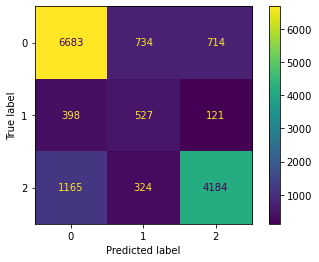

In [30]:
plot_confusion_matrix(estimator=rfc_smote_model_pipe_dropped_vars, X=X_test, y_true=y_test)

## Optimized Random Forest  

In [9]:
optimal_rfc_model_pipe = Pipeline(steps=[('ct', CT), ('rfc', RandomForestClassifier(
      criterion='gini', min_samples_leaf=5, n_estimators=100))])

optimal_rfc_model_pipe.fit(X_train, y_train)



Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                 

In [1]:
optimal_rfc_model_pipe.score(X_train, y_train)

NameError: name 'optimal_rfc_model_pipe' is not defined

In [11]:
cat_features_list = list(optimal_rfc_model_pipe.named_steps["ct"].named_transformers_["subpipe_cat"].named_steps["ohe"].get_feature_names())

In [12]:
features_names = ["amount_tsh", "gps_height"] + cat_features_list + ["unknown_construction_yr", "age_at_inspection", "water_per_person"]

In [14]:
optimal_rfc_importances = optimal_rfc_model_pipe.named_steps["rfc"].feature_importances_

In [16]:
optimal_rfc_feature_importance_dict = dict(zip(features_names, optimal_rfc_importances)) 

In [18]:
sort_rfc_feature_importance = sorted(optimal_rfc_feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

for i in sort_rfc_feature_importance:
    print(i[0], i[1])

x13_insufficient 0.13314590420268896
x0_Internal 0.05819842554656524
age_at_inspection 0.04578139276283127
x7_other motorpump 0.04337504409361148
x13_seasonal 0.04242226770433083
gps_height 0.036628901723765754
x8_submersible 0.031800299071269175
amount_tsh 0.030126486826594266
x0_Lake Nyasa 0.025982364410185758
x16_dam 0.016861187928049203
x13_unknown 0.016047594586819303
x11_pay annually 0.01586052387456499
x8_other 0.013224560355777043
x16_hand pump 0.012853963550742326
x16_other 0.011830488760469417
x13_enough 0.011457798456746509
x7_india mark iii 0.011340559845155293
x8_motorpump 0.010829011715406893
x9_water board 0.008800538526678614
x15_groundwater 0.008593548098256165
x7_other handpump 0.008367204268347929
x11_unknown 0.007760733515065111
x11_pay when scheme fails 0.007359426192135294
x7_afridev 0.007219518222228777
x1_Kigoma 0.007160243795654914
x5_WUG 0.00703869880319329
x14_unknown 0.006592245468133914
x12_fluoride 0.006452199351362744
x16_cattle trough 0.00631687623858512

In [19]:
cleaned_water_pump["quantity"].value_counts()

enough          33185
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

In [22]:
X_train.drop(["lga", "management", "region_code"], axis=1, inplace=True)

KeyError: "['lga' 'management' 'region_code'] not found in axis"

In [23]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44549 entries, 42186 to 56422
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   amount_tsh               44549 non-null  float64
 1   gps_height               44549 non-null  int64  
 2   basin                    44549 non-null  object 
 3   region                   44549 non-null  object 
 4   public_meeting           44549 non-null  object 
 5   scheme_management        44549 non-null  object 
 6   permit                   44549 non-null  object 
 7   extraction_type_group    44549 non-null  object 
 8   extraction_type_class    44549 non-null  object 
 9   management_group         44549 non-null  object 
 10  payment                  44549 non-null  object 
 11  quality_group            44549 non-null  object 
 12  quantity                 44549 non-null  object 
 13  source                   44549 non-null  object 
 14  source_class      

In [25]:
new_cat_cols = ["basin", "region", "public_meeting", "scheme_management", "permit",
          "extraction_type_group", "extraction_type_class", "management_group", "payment", "quality_group",
          "quantity", "source", "source_class", "waterpoint_type"]

In [26]:
subpipe_cat_new = Pipeline(steps=[("ohe", OneHotEncoder(sparse=False, handle_unknown="ignore"))])

In [27]:
CT_new = ColumnTransformer(transformers=[
                                    ("subpipe_num", subpipe_num, numeric_cols), 
                                     ("subpipe_cat_new", subpipe_cat_new, new_cat_cols),
                                    ("subpipe_ord", subpipe_ord, bool_cols)
                                    ], 
                       remainder="drop"
                      )

In [28]:
optimal_rfc_model_pipe_2 = Pipeline(steps=[('ct_new', CT_new), ('rfc', RandomForestClassifier(
      criterion='gini', min_samples_leaf=5, n_estimators=100))])

optimal_rfc_model_pipe_2.fit(X_train, y_train)

Pipeline(steps=[('ct_new',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat_new',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
         

In [31]:
optimal_rfc_model_pipe_2.score(X_train, y_train)

0.805270600911356

In [35]:
X_test.drop(["lga", "management", "region_code"], axis=1, inplace=True)

/Users/margaretboland/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [36]:
y_pred_optimal_2 = optimal_rfc_model_pipe_2.predict(X_test)

In [38]:
print(classification_report(y_test, y_pred_optimal_2))

              precision    recall  f1-score   support

           0       0.76      0.92      0.83      8131
           1       0.62      0.14      0.23      1046
           2       0.84      0.70      0.77      5673

    accuracy                           0.78     14850
   macro avg       0.74      0.59      0.61     14850
weighted avg       0.78      0.78      0.76     14850

